# **Project Overview: Cross-Disciplinary Paper Recommendations**

This project leverages transformer-based models, specifically BERT (Bidirectional Encoder Representations from Transformers), to recommend academic research papers across disciplines. The system analyzes the semantic content of paper titles and abstracts, generating dense vector embeddings that capture meaning beyond keywords. These embeddings are then compared to identify conceptual similarities between papers.

The primary objective is to foster cross-disciplinary connections by recommending research that may be relevant to researchers in different academic domains. For example, a paper in computer science may be suggested to a neuroscience researcher based on conceptual overlap in abstracts.

## **The workflow consists of several key stages:**

*   Data Preprocessing: Cleaning and transforming the raw data from the dataset, including removing duplicates and handling missing values.
*   Embedding Generation: Using a pre-trained BERT model to generate dense embeddings for paper titles and abstracts, ensuring that each paper's semantic content is captured accurately.
*   Similarity Computation: Calculating the cosine similarity between papers' embeddings to determine how closely related they are.
*   Topic Modeling with LDA: Applying Latent Dirichlet Allocation (LDA) to uncover latent topics in research papers, helping to identify key themes across disciplines.
*   Visualization: Using techniques like heatmaps, PCA, and dimensionality reduction methods to visualize the relationships and similarities between papers.

By implementing these steps, this project aims to not only recommend relevant papers but also uncover potential intersections between research areas that can lead to novel discoveries.

In [1]:
#!pip install --upgrade --force-reinstall nltk
#!pip install torch
#!pip install transformers==4.28.1
#!pip install sentence-transformers==2.2.2
#!pip install huggingface_hub==0.13.4
#!pip install deepspeed
#!pip install sentencepiece

In [2]:
import os
import zipfile
import pandas as pd
import numpy as np
import re
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from transformers import BertTokenizer, BertModel
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF


#NOTE: 
from sentence_transformers import SentenceTransformer


### Download and Load Arxiv Dataset
Download and extract the Arxiv dataset from Kaggle, then load and display the data using pandas.

- This dataset includes titles, abstracts, authors, and categories for academic papers across fields like
  computer science, physics, and math.

- Since the full dataset is extremely large, 10,000 rows are used to make processing and analysis easier.

In [3]:

# Download arxiv zip file
#!kaggle datasets download -d cornell-university/arxiv --force

# Ensure zip file is in loaded directory
print("Files in current directory:", os.listdir())

# Extract the dataset
with zipfile.ZipFile("arxiv.zip", "r") as zip_ref:
    zip_ref.extractall("arxiv_data")

# List extracted files
print("Extracted files:", os.listdir("arxiv_data"))

# Read the first 10,000 rows
df = pd.read_json("arxiv_data/arxiv-metadata-oai-snapshot.json", lines=True, nrows=10000)
df.head()

Files in current directory: ['.git', 'arxiv.zip', 'arxiv_data', 'CP421 - Project Code.ipynb', 'model_cache', 'README.md']
Extracted files: ['arxiv-metadata-oai-snapshot.json']


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


### Mapping Category Labels and Assigning Subject Areas
The dataset uses abbreviated category labels (e.g., cs.LG for Machine Learning), which are compact but not always intuitive for analysis. To improve interpretability, these codes are mapped to their full descriptive names. Additionally, to better group research areas, a subject mapping process is applied. This categorizes papers into broader subject areas, such as Computer Science, Mathematics, and Physics, based on their assigned categories.

Each paper's primary category is extracted and mapped to its full name using a predefined dictionary. Afterward, papers are assigned a subject label based on a second mapping that consolidates related categories. If a category is not found in the predefined mappings, it is labeled as "Unknown Category" or "Unknown Subject", ensuring data consistency.

By applying this mapping, we facilitate more effective filtering, visualization, and cross-disciplinary analysis of research trends.

In [4]:
# Dictionary of categories and full names to be mapped
category_map = {
    'astro-ph': 'Astrophysics',
    'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
    'astro-ph.EP': 'Earth and Planetary Astrophysics',
    'astro-ph.GA': 'Astrophysics of Galaxies',
    'astro-ph.HE': 'High Energy Astrophysical Phenomena',
    'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
    'astro-ph.SR': 'Solar and Stellar Astrophysics',
    'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
    'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
    'cond-mat.mtrl-sci': 'Materials Science',
    'cond-mat.other': 'Other Condensed Matter',
    'cond-mat.quant-gas': 'Quantum Gases',
    'cond-mat.soft': 'Soft Condensed Matter',
    'cond-mat.stat-mech': 'Statistical Mechanics',
    'cond-mat.str-el': 'Strongly Correlated Electrons',
    'cond-mat.supr-con': 'Superconductivity',
    'cs.AI': 'Artificial Intelligence',
    'cs.AR': 'Hardware Architecture',
    'cs.CC': 'Computational Complexity',
    'cs.CE': 'Computational Engineering, Finance, and Science',
    'cs.CG': 'Computational Geometry',
    'cs.CL': 'Computation and Language',
    'cs.CR': 'Cryptography and Security',
    'cs.CV': 'Computer Vision and Pattern Recognition',
    'cs.CY': 'Computers and Society',
    'cs.DB': 'Databases',
    'cs.DC': 'Distributed, Parallel, and Cluster Computing',
    'cs.DL': 'Digital Libraries',
    'cs.DM': 'Discrete Mathematics',
    'cs.DS': 'Data Structures and Algorithms',
    'cs.ET': 'Emerging Technologies',
    'cs.FL': 'Formal Languages and Automata Theory',
    'cs.GL': 'General Literature',
    'cs.GR': 'Graphics',
    'cs.GT': 'Computer Science and Game Theory',
    'cs.HC': 'Human-Computer Interaction',
    'cs.IR': 'Information Retrieval',
    'cs.IT': 'Information Theory',
    'cs.LG': 'Machine Learning',
    'cs.LO': 'Logic in Computer Science',
    'cs.MA': 'Multiagent Systems',
    'cs.MM': 'Multimedia',
    'cs.MS': 'Mathematical Software',
    'cs.NA': 'Numerical Analysis',
    'cs.NE': 'Neural and Evolutionary Computing',
    'cs.NI': 'Networking and Internet Architecture',
    'cs.OH': 'Other Computer Science',
    'cs.OS': 'Operating Systems',
    'cs.PF': 'Performance',
    'cs.PL': 'Programming Languages',
    'cs.RO': 'Robotics',
    'cs.SC': 'Symbolic Computation',
    'cs.SD': 'Sound',
    'cs.SE': 'Software Engineering',
    'cs.SI': 'Social and Information Networks',
    'cs.SY': 'Systems and Control',
    'econ.EM': 'Econometrics',
    'eess.AS': 'Audio and Speech Processing',
    'eess.IV': 'Image and Video Processing',
    'eess.SP': 'Signal Processing',
    'gr-qc': 'General Relativity and Quantum Cosmology',
    'hep-ex': 'High Energy Physics - Experiment',
    'hep-lat': 'High Energy Physics - Lattice',
    'hep-ph': 'High Energy Physics - Phenomenology',
    'hep-th': 'High Energy Physics - Theory',
    'math.AC': 'Commutative Algebra',
    'math.AG': 'Algebraic Geometry',
    'math.AP': 'Analysis of PDEs',
    'math.AT': 'Algebraic Topology',
    'math.CA': 'Classical Analysis and ODEs',
    'math.CO': 'Combinatorics',
    'math.CT': 'Category Theory',
    'math.CV': 'Complex Variables',
    'math.DG': 'Differential Geometry',
    'math.DS': 'Dynamical Systems',
    'math.FA': 'Functional Analysis',
    'math.GM': 'General Mathematics',
    'math.GN': 'General Topology',
    'math.GR': 'Group Theory',
    'math.GT': 'Geometric Topology',
    'math.HO': 'History and Overview',
    'math.IT': 'Information Theory',
    'math.KT': 'K-Theory and Homology',
    'math.LO': 'Logic',
    'math.MG': 'Metric Geometry',
    'math.MP': 'Mathematical Physics',
    'math.NA': 'Numerical Analysis',
    'math.NT': 'Number Theory',
    'math.OA': 'Operator Algebras',
    'math.OC': 'Optimization and Control',
    'math.PR': 'Probability',
    'math.QA': 'Quantum Algebra',
    'math.RA': 'Rings and Algebras',
    'math.RT': 'Representation Theory',
    'math.SG': 'Symplectic Geometry',
    'math.SP': 'Spectral Theory',
    'math.ST': 'Statistics Theory',
    'math-ph': 'Mathematical Physics',
    'nlin.AO': 'Adaptation and Self-Organizing Systems',
    'nlin.CD': 'Chaotic Dynamics',
    'nlin.CG': 'Cellular Automata and Lattice Gases',
    'nlin.PS': 'Pattern Formation and Solitons',
    'nlin.SI': 'Exactly Solvable and Integrable Systems',
    'nucl-ex': 'Nuclear Experiment',
    'nucl-th': 'Nuclear Theory',
    'physics.acc-ph': 'Accelerator Physics',
    'physics.ao-ph': 'Atmospheric and Oceanic Physics',
    'physics.app-ph': 'Applied Physics',
    'physics.atm-clus': 'Atomic and Molecular Clusters',
    'physics.atom-ph': 'Atomic Physics',
    'physics.bio-ph': 'Biological Physics',
    'physics.chem-ph': 'Chemical Physics',
    'physics.class-ph': 'Classical Physics',
    'physics.comp-ph': 'Computational Physics',
    'physics.data-an': 'Data Analysis, Statistics and Probability',
    'physics.ed-ph': 'Physics Education',
    'physics.flu-dyn': 'Fluid Dynamics',
    'physics.gen-ph': 'General Physics',
    'physics.geo-ph': 'Geophysics',
    'physics.hist-ph': 'History and Philosophy of Physics',
    'physics.ins-det': 'Instrumentation and Detectors',
    'physics.med-ph': 'Medical Physics',
    'physics.optics': 'Optics',
    'physics.plasm-ph': 'Plasma Physics',
    'physics.pop-ph': 'Popular Physics',
    'physics.soc-ph': 'Physics and Society',
    'physics.space-ph': 'Space Physics',
    'q-bio.BM': 'Biomolecules',
    'q-bio.CB': 'Cell Behavior',
    'q-bio.GN': 'Genomics',
    'q-bio.MN': 'Molecular Networks',
    'q-bio.NC': 'Neurons and Cognition',
    'q-bio.OT': 'Other Quantitative Biology',
    'q-bio.PE': 'Populations and Evolution',
    'q-bio.QM': 'Quantitative Methods',
    'q-bio.SC': 'Subcellular Processes',
    'q-bio.TO': 'Tissues and Organs',
    'q-fin.CP': 'Computational Finance',
    'q-fin.EC': 'Economics',
    'q-fin.GN': 'General Finance',
    'q-fin.MF': 'Mathematical Finance',
    'q-fin.PM': 'Portfolio Management',
    'q-fin.PR': 'Pricing of Securities',
    'q-fin.RM': 'Risk Management',
    'q-fin.ST': 'Statistical Finance',
    'q-fin.TR': 'Trading and Market Microstructure',
    'quant-ph': 'Quantum Physics',
    'stat.AP': 'Applications',
    'stat.CO': 'Computation',
    'stat.ME': 'Methodology',
    'stat.ML': 'Machine Learning',
    'stat.OT': 'Other Statistics',
    'stat.TH': 'Statistics Theory'
}

subject_map = {
    "Astrophysics & Cosmology": ["astro-ph", "astro-ph.CO", "astro-ph.EP", "astro-ph.GA", "astro-ph.HE", "astro-ph.IM", "astro-ph.SR"],
    "Condensed Matter Physics": ["cond-mat.dis-nn", "cond-mat.mes-hall", "cond-mat.mtrl-sci", "cond-mat.other", "cond-mat.quant-gas", "cond-mat.soft", "cond-mat.stat-mech", "cond-mat.str-el", "cond-mat.supr-con"],
    "Computer Science": ["cs.AI", "cs.AR", "cs.CC", "cs.CE", "cs.CG", "cs.CL", "cs.CR", "cs.CV", "cs.CY", "cs.DB", "cs.DC", "cs.DL", "cs.DM", "cs.DS", "cs.ET", "cs.FL", "cs.GL", "cs.GR", "cs.GT", "cs.HC", "cs.IR", "cs.IT", "cs.LG", "cs.LO", "cs.MA", "cs.MM", "cs.MS", "cs.NA", "cs.NE", "cs.NI", "cs.OH", "cs.OS", "cs.PF", "cs.PL", "cs.RO", "cs.SC", "cs.SD", "cs.SE", "cs.SI", "cs.SY"],
    "Econometrics & Finance": ["econ.EM", "q-fin.CP", "q-fin.EC", "q-fin.GN", "q-fin.MF", "q-fin.PM", "q-fin.PR", "q-fin.RM", "q-fin.ST", "q-fin.TR"],
    "Electrical Engineering & Signal Processing": ["eess.AS", "eess.IV", "eess.SP"],
    "General & Theoretical Physics": ["gr-qc", "hep-ex", "hep-lat", "hep-ph", "hep-th", "math-ph", "physics.acc-ph", "physics.ao-ph", "physics.app-ph", "physics.atm-clus", "physics.atom-ph", "physics.bio-ph", "physics.chem-ph", "physics.class-ph", "physics.comp-ph", "physics.data-an", "physics.ed-ph", "physics.flu-dyn", "physics.gen-ph", "physics.geo-ph", "physics.hist-ph", "physics.ins-det", "physics.med-ph", "physics.optics", "physics.plasm-ph", "physics.pop-ph", "physics.soc-ph", "physics.space-ph", "quant-ph"],
    "Mathematics": ["math.AC", "math.AG", "math.AP", "math.AT", "math.CA", "math.CO", "math.CT", "math.CV", "math.DG", "math.DS", "math.FA", "math.GM", "math.GN", "math.GR", "math.GT", "math.HO", "math.IT", "math.KT", "math.LO", "math.MG", "math.MP", "math.NA", "math.NT", "math.OA", "math.OC", "math.PR", "math.QA", "math.RA", "math.RT", "math.SG", "math.SP", "math.ST"],
    "Nonlinear Sciences": ["nlin.AO", "nlin.CD", "nlin.CG", "nlin.PS", "nlin.SI"],
    "Nuclear Physics": ["nucl-ex", "nucl-th"],
    "Quantitative Biology": ["q-bio.BM", "q-bio.CB", "q-bio.GN", "q-bio.MN", "q-bio.NC", "q-bio.OT", "q-bio.PE", "q-bio.QM", "q-bio.SC", "q-bio.TO"],
    "Statistics & Data Science": ["stat.AP", "stat.CO", "stat.ME", "stat.ML", "stat.OT", "stat.TH"]
}

# If there are multiple categories associated with the document, take the first one
df['categories'] = df['categories'].str.split().str[0]

# Add subjects instead of the category
category_to_subject = {}
for subject, categories in subject_map.items():
    for category in categories:
        category_to_subject[category] = subject

# Apply the corrected mapping
df['mapped_categories'] = df['categories'].map(category_map)
df['subject_map'] = df['categories'].map(category_to_subject)
df['mapped_categories'] = df['mapped_categories'].fillna('Unknown Category') #should not exist
df['subject_map'] = df['subject_map'].fillna('Unknown Subject')  #should not exist

# Print unique subject mappings (ie. without duplicates)
df[['categories', 'mapped_categories', 'subject_map']].drop_duplicates().head(5)

,categories,mapped_categories,subject_map
0,hep-ph,High Energy Physics - Phenomenology,General & Theoretical Physics
1,math.CO,Combinatorics,Mathematics
2,physics.gen-ph,General Physics,General & Theoretical Physics
4,math.CA,Classical Analysis and ODEs,Mathematics
5,cond-mat.mes-hall,Mesoscale and Nanoscale Physics,Condensed Matter Physics


### Data Cleaning and Preprocessing
The following step involves cleaning and preprocessing the dataset by addressing missing values, standardizing text, and removing duplicate entries.

The significance of this step is as follows:

- Some records may have missing titles or abstracts, which are crucial for meaningful analysis. These rows are removed to ensure the dataset contains only complete and usable information.
- Text data often contains extra spaces, punctuation marks, and inconsistencies in casing, which can hinder natural language processing (NLP) tasks. Standardizing the text ensures it is in a consistent and analyzable format.
- Duplicate records, which contain identical titles and abstracts, are eliminated to prevent redundancy and maintain the integrity of the dataset.

In [5]:
# Drop rows where 'title' or 'abstract' are missing
df_cleaned = df.dropna(subset=['title', 'abstract'])

# Function to clean text
def clean_text(text):
    # Remove extra spaces and special characters
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

# Apply text cleaning to 'title' and 'abstract' columns
df_cleaned['title'] = df_cleaned['title'].apply(clean_text)
df_cleaned['abstract'] = df_cleaned['abstract'].apply(clean_text)

# Remove duplicate rows based on 'title' and 'abstract'
df_cleaned = df_cleaned.drop_duplicates(subset=['title', 'abstract'])

# Display the cleaned dataframe shape
print(df_cleaned.shape)

(10000, 16)


### NOTE: Cleaning And Reformatting Authorship Data

- Additional piece of formatting that works to clean the messily stored author data

In [6]:
"""
Reformats Author Data Into Clean List
"""
def clean_contributors(author_string):

    #Remove Anything In Brackets
    s = re.sub(r'\([^)]*\)', '', author_string)

    #Remove All "and"
    s = re.sub(r'\band\b', '', s, flags=re.IGNORECASE)

    #Remove All "\n"
    s = s.replace('\n', '') 

    #Split And Trim
    return [part.strip() for part in s.split(',') if part.strip()]
    
#Cleans The Author Columns
df_cleaned['authors_parsed'] = df_cleaned['authors'].apply(clean_contributors)
df_cleaned = df_cleaned.drop(columns='authors')

#Store Count
df_cleaned['contributors'] = df['authors_parsed'].apply(len)

#Order 
df_cleaned = df_cleaned.sort_values(by='id')

### Distribution of Research

This code visualizes the distribution of research papers in the dataset both before and after category mapping.

First, it plots the distribution based on the default categories assigned by arXiv.This helps us see how papers are initially distributed across various categories.

Next, it shows the distribution after condensing the categories using a custom mapping.This step results in clearer visualizations, as there are more papers in each category, and it resolves the issue of 'unknown' categories by consolidating them into defined ones.

C:\Users\ldunc\AppData\Local\Temp\ipykernel_4224\3289940194.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts_original.index, y=category_counts_original.values,palette='Set2')


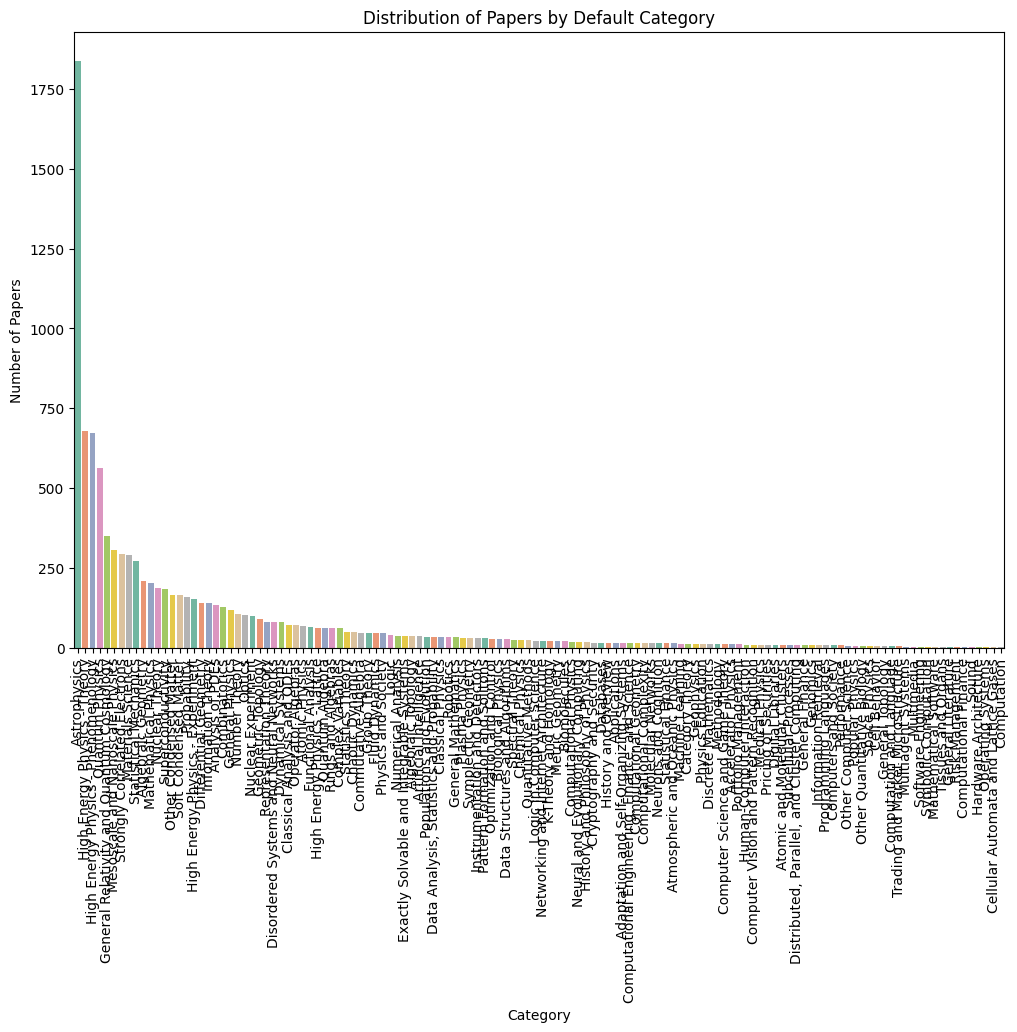

C:\Users\ldunc\AppData\Local\Temp\ipykernel_4224\3289940194.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts_condensed.index, y=category_counts_condensed.values, palette='Set2',)


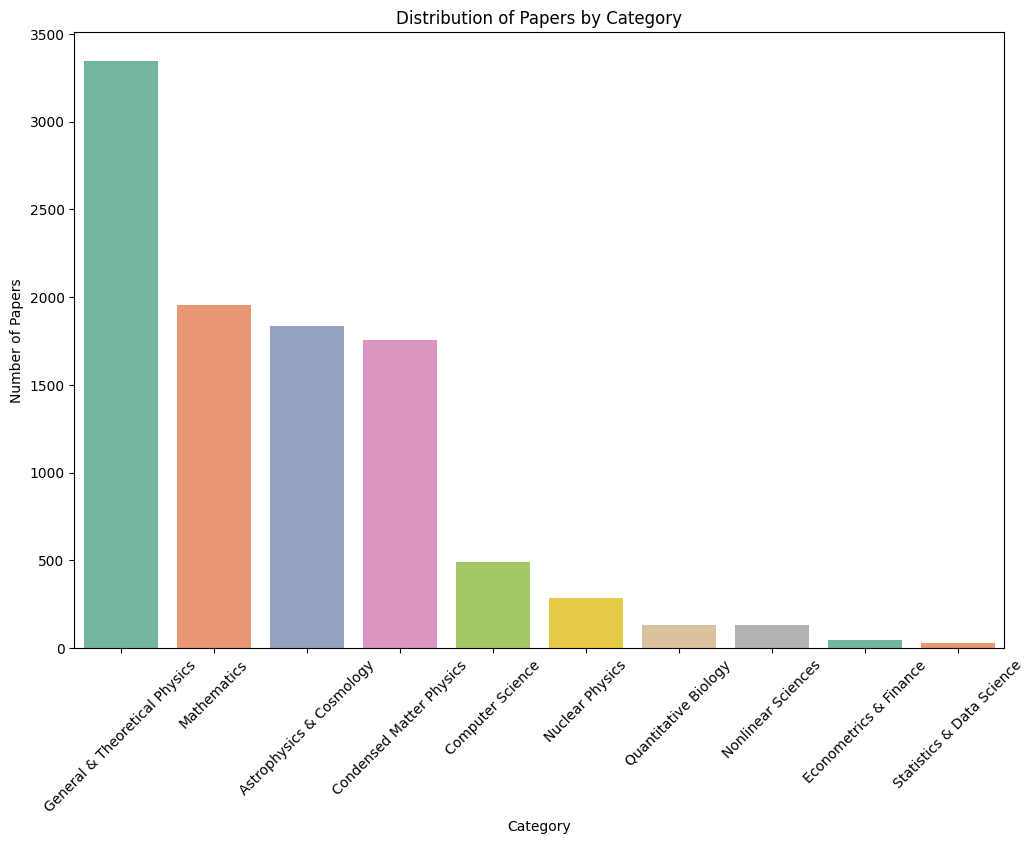

In [7]:
# Count the number of papers in each category to see how the dataset is distributed
category_counts_original = df_cleaned['mapped_categories'].value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(x=category_counts_original.index, y=category_counts_original.values,palette='Set2')
plt.title('Distribution of Papers by Default Category')
plt.xlabel('Category')
plt.ylabel('Number of Papers')
plt.xticks(rotation=90)
plt.show()

category_counts_condensed = df_cleaned['subject_map'].value_counts()

# Plot for condensed category map
categories = sorted(df_cleaned['mapped_categories'].unique())
subjects = sorted(df_cleaned['subject_map'].unique())

# Define a fixed color palette
palette = sns.color_palette("tab10", max(len(categories), len(subjects)))
category_counts = df_cleaned['subject_map'].value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(x=category_counts_condensed.index, y=category_counts_condensed.values, palette='Set2',)
plt.title('Distribution of Papers by Category')
plt.xlabel('Category')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45)
plt.show()

### Processing Dates and Visualizing Publication Trends
This code processes the dataset by converting the update date to a proper datetime format and extracting the year. It then filters out the "Unknown Category" rows. The plot_percentage_trends function calculates the percentage of papers published each year per subject category and visualizes these trends over time using line plots. The goal is to show how different research areas have evolved over the years in terms of their publication volume.

C:\Users\ldunc\AppData\Local\Temp\ipykernel_4224\1736065419.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=category_percentage.columns, y=category_percentage.loc[category], marker='o', label=category, palette='Set2')
C:\Users\ldunc\AppData\Local\Temp\ipykernel_4224\1736065419.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=category_percentage.columns, y=category_percentage.loc[category], marker='o', label=category, palette='Set2')
C:\Users\ldunc\AppData\Local\Temp\ipykernel_4224\1736065419.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=category_percentage.columns, y=category_percentage.loc[category], marker='o', label=category, palette='Set2')
C:\Users\ldunc\AppData\Local\Temp\ipykernel_4224\1736065419.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=category_percentage.column

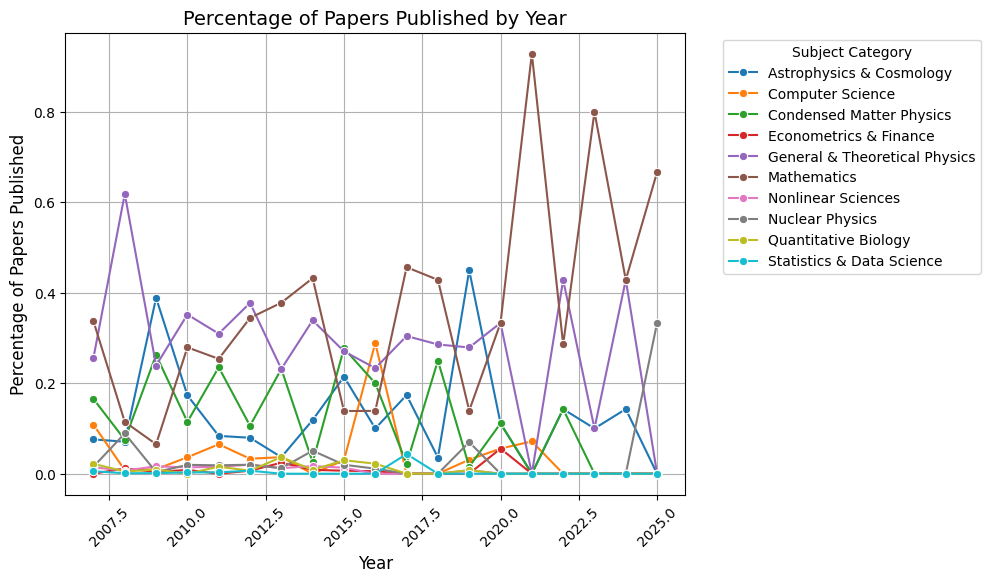

In [8]:
# Convert the update date to a proper datetime format
df_cleaned['update_date'] = pd.to_datetime(df_cleaned['update_date'], errors='coerce')

# Extract the year from the update date
df_cleaned['year'] = df_cleaned['update_date'].dt.year

# Exclude rows where the category is "Unknown Category"
df_filtered = df_cleaned[df_cleaned['mapped_categories'] != 'Unknown Category']

# Split the dataset into pre-2010 and post-2010 categories for analysis
def plot_percentage_trends(df, title):
    # Calculate the total number of papers per year
    total_papers_per_year = df.groupby('year').size()

    # Count papers per subject and year
    category_trends = df.groupby(['subject_map', 'year']).size().unstack(fill_value=0)

    # Convert counts to percentages
    category_percentage = category_trends.div(total_papers_per_year, axis=1)

    # Plot the temporal trends for each category as percentages
    plt.figure(figsize=(8, 6))

    for category in category_percentage.index:
        sns.lineplot(x=category_percentage.columns, y=category_percentage.loc[category], marker='o', label=category, palette='Set2')

    plt.title(title, fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Percentage of Papers Published', fontsize=12)
    plt.legend(title='Subject Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.xticks(rotation=45)

    plt.show()

# Plot temporal trends by category as percentages
plot_percentage_trends(df_filtered, 'Percentage of Papers Published by Year')

### Summary Statistics for Category Distribution
The following code calculates and visualizes summary statistics for both the original categories ('mapped_categories') and the condensed categories ('subject_map'). It provides insights into the distribution of papers across categories, highlighting the most and least frequent categories, as well as the mean and standard deviation of papers per category. These statistics are important for understanding the dataset's structure and identifying potential imbalances between categories, which can guide further analysis and model development.

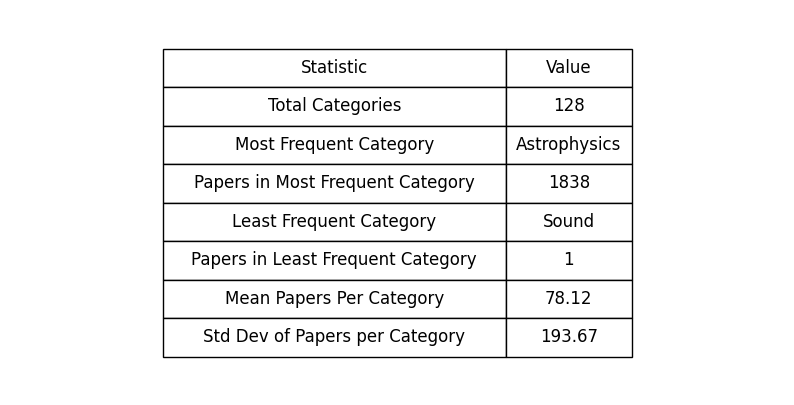

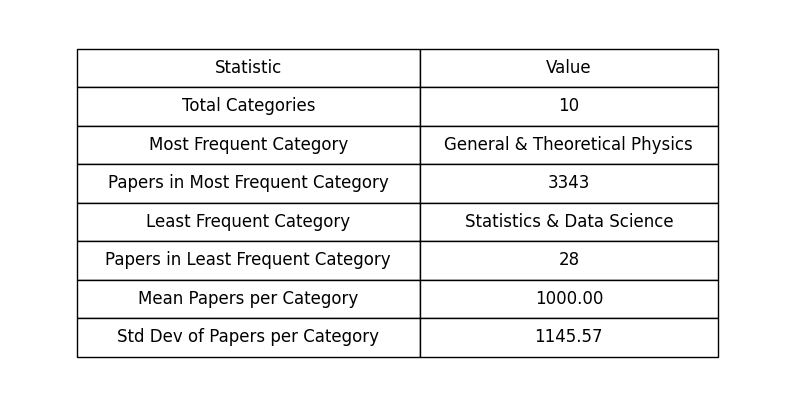

In [9]:
# Summary statistics for default categories
num_categories = category_counts_original.shape[0]
most_frequent_category = category_counts_original.idxmax()
most_frequent_count = category_counts_original.max()
least_frequent_category = category_counts_original.idxmin()
least_frequent_count = category_counts_original.min()
mean_papers_per_category = category_counts_original.mean()
std_dev_papers_per_category = category_counts_original.std()

# Prepare the stats for the table
summary_stats_default = [
    ["Total Categories", num_categories],
    ["Most Frequent Category",most_frequent_category],
    ["Papers in Most Frequent Category", most_frequent_count],
    ["Least Frequent Category",  least_frequent_category],
    ["Papers in Least Frequent Category",least_frequent_count],
    ["Mean Papers Per Category",f"{mean_papers_per_category:.2f}"],
    ["Std Dev of Papers per Category", f"{std_dev_papers_per_category:.2f}"]
]

# Generate Table
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=summary_stats_default, colLabels=["Statistic", "Value"],cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width([0, 1])

# Adjust row heights so table is less squished
for (row, col),cell in table.get_celld().items():
      cell.set_height(0.1)

plt.show()

# Summary statistics condensed categories
num_categories = category_counts_condensed.shape[0]
most_frequent_category = category_counts_condensed.idxmax()
most_frequent_count = category_counts_condensed.max()
least_frequent_category = category_counts_condensed.idxmin()
least_frequent_count = category_counts_condensed.min()
mean_papers_per_category = category_counts_condensed.mean()
std_dev_papers_per_category =category_counts_condensed.std()

# Prepare the stats for the table
summary_stats_condensed = [
    ["Total Categories", num_categories],
    ["Most Frequent Category",most_frequent_category],
    ["Papers in Most Frequent Category",most_frequent_count],
    ["Least Frequent Category",least_frequent_category],
    ["Papers in Least Frequent Category",least_frequent_count],
    ["Mean Papers per Category", f"{mean_papers_per_category:.2f}"],
    ["Std Dev of Papers per Category", f"{std_dev_papers_per_category:.2f}"]
]

# Table
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText = summary_stats_condensed, colLabels=["Statistic", "Value"], cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width([0, 1])

# Adjust row heights
for (row, col), cell in table.get_celld().items():
      cell.set_height(0.1)

plt.show()

### Tokenization and Embedding Extraction

This step utilizes a pre-trained BERT model to generate numerical embeddings for the titles and abstracts of research papers, enabling the use of these embeddings for various natural language processing (NLP) tasks.

The significance of this step is as follows:

- Converting Text into Numerical Data: Machine learning models perform optimally with numerical data. Textual data must be transformed into structured numerical representations to facilitate analysis. BERT embeddings provide a more sophisticated approach, capturing the contextual meaning of text more effectively than traditional methods such as TF-IDF.
- Leveraging Pre-Trained Knowledge: Instead of training a model from scratch, we leverage the pre-trained BERT model (bert-base-uncased), which has been trained on a vast corpus of text data. This provides us with high-quality and context-aware embeddings, eliminating the need for domain-specific training.
- Application to NLP Tasks: The embeddings generated from the titles and abstracts serve as the foundation for several NLP tasks, such as document similarity, topic modeling, research trend analysis, or even training classifiers for more advanced analysis.

### NOTE: Addition To Embedding Extraction

- Added a wrapper to existing method, to allow choice between one of 2 methods, (existing BERT or Sentence Based)
- Currently Sentence Based (the current model at least) is smaller and quicker then BERT (although there are sentence based ones which are larger)

In [10]:
#Models Used
model_full_bert = 'bert-base-uncased'
model_sentence = 'all-MiniLM-L6-v2'

#Tokenizers And Models Required
full_tokenizer = BertTokenizer.from_pretrained(model_full_bert, ignore_mismatched_sizes=True)
full_model = BertModel.from_pretrained(model_full_bert, ignore_mismatched_sizes=True)
sentence_model = SentenceTransformer(model_sentence)

"""
Your Original Method: Averaging Word Embeddings, Better For Finding Keyword Similarity
"""
def original_token_embedding(text):

        inputs = full_tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)

        with torch.no_grad(): outputs = full_model(**inputs)

        embeddings = outputs.last_hidden_state.mean(dim=1)

        return embeddings.numpy().flatten()

"""
Generates Embedding According To Chosen Method
"""
def generate_embeddings(method, applied_on):
        if method == "token":
                return applied_on.apply(original_token_embedding)
        else:
                return list(sentence_model.encode(applied_on.tolist(), batch_size=128, show_progress_bar=True))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### NOTE: Generating Embedding

- In addition to what you had already, I added the compound utilizing the sentence method, to demonstrate using the other approach
- It seems to me, that generating multiple and comparing these embeddings IE: (title, abstract, joined x token, sentence) might be interesting

- ALTERNATIVE COMBOS CAN BE TRIED

In [11]:
#NOTE: sentence has progress bar
df_cleaned['joined_embeddings'] = generate_embeddings('sentence', df_cleaned['title'] + ":" + df_cleaned['abstract'])  
df_cleaned['title_embeddings'] = generate_embeddings('token', df_cleaned['title'])
df_cleaned['abstract_embeddings'] = generate_embeddings('token', df_cleaned['abstract'])


Batches:   0%|          | 0/79 [00:00<?, ?it/s]

### NOTE: Generating Alternative Method

- So the previous embedding is based on language models, whats below is very similar but puts the embedding through a layer to incorporate tendencies for co-authorship and category overlap among authors
- To do this, I start by making 2 new dataframes, one (df_contributions) to represent an authors contribution to a single paper, and a second (df_authors) to store aggregate information about each author
- Some information is then merged, which is redundant space wise, but makes the code easier

In [12]:
df_contributions = (
    df_cleaned
    .assign(
        contributors = df_cleaned["authors_parsed"].apply(len)
    )
    .explode("authors_parsed", ignore_index=True)
    .rename(columns={"authors_parsed":"contributor"})
    .assign(
        is_lead = lambda d: d.apply(lambda row: any(w.lower() in re.split(r'[^A-Za-z]+', row['contributor'].lower()) for w in re.split(r'[^A-Za-z]+', row['submitter'].lower())), axis=1)
    )
    .loc[:, lambda d: ~d.columns.isin(["authors_parsed","unclean_contributor", "submitter", "authors", "comments", "journal-ref", "doi", "license", "versions", "update_date", "report-no", "categories", "title", "abstract"])]
)
df_contributions.head(1)

,id,contributor,mapped_categories,subject_map,contributors,year,joined_embeddings,title_embeddings,abstract_embeddings,is_lead
0,704.0001,C. Bal\'azs,High Energy Physics - Phenomenology,General & Theoretical Physics,4,2008,"[-0.13270834, -0.018693868, -0.015380211, 0.02...","[-0.010558279, -0.22632624, 0.10145383, 0.0742...","[-0.34230632, -0.0080496315, 0.35110375, -0.07...",False


In [13]:
df_authors = (
    df_contributions
    .groupby("contributor")
    .agg(
        papers = ('id', 'count'),
        earliest = ('year', 'min'),
        latest = ('year', 'max'),
        solo = ('contributors', lambda x: (x==1).sum()),
        average_size = ('contributors', 'mean'),
        mapped_category_count = ('mapped_categories', lambda x: x.dropna().nunique()),
        subject_map_count = ('subject_map', lambda x: x.dropna().nunique())
    )
    .reset_index()
)
df_authors.head(1)

,contributor,papers,earliest,latest,solo,average_size,mapped_category_count,subject_map_count
0,31 co-authors,1,2010,2010,0,7.0,1,1


In [14]:
df_contributions = df_contributions.merge(df_authors[['contributor', 'earliest', 'latest', 'papers']], on='contributor', how='left')

In [15]:
paper_sums = df_contributions.groupby('id')['papers'].sum().reset_index(name='total_papers')
df_cleaned = df_cleaned.merge(paper_sums, on='id', how='left')

### NOTE: Distribution Of Authorship

- Displaying the distributions generated within the author and contribution dataframe
- Most importantly, illustrating how many papers each authors writes (Paper Counts By Author), the number of solo papers written by each author (Single Paper Counts By Author), The number of categories each author has written papers within (Categories Per Authors), similarly the number of subjects (Subjects Per Author), The Counting Publishing Ratio, which stores for a given paper, the number of papers written by its authors divided by how many authors it has (metric for experience of authors) 

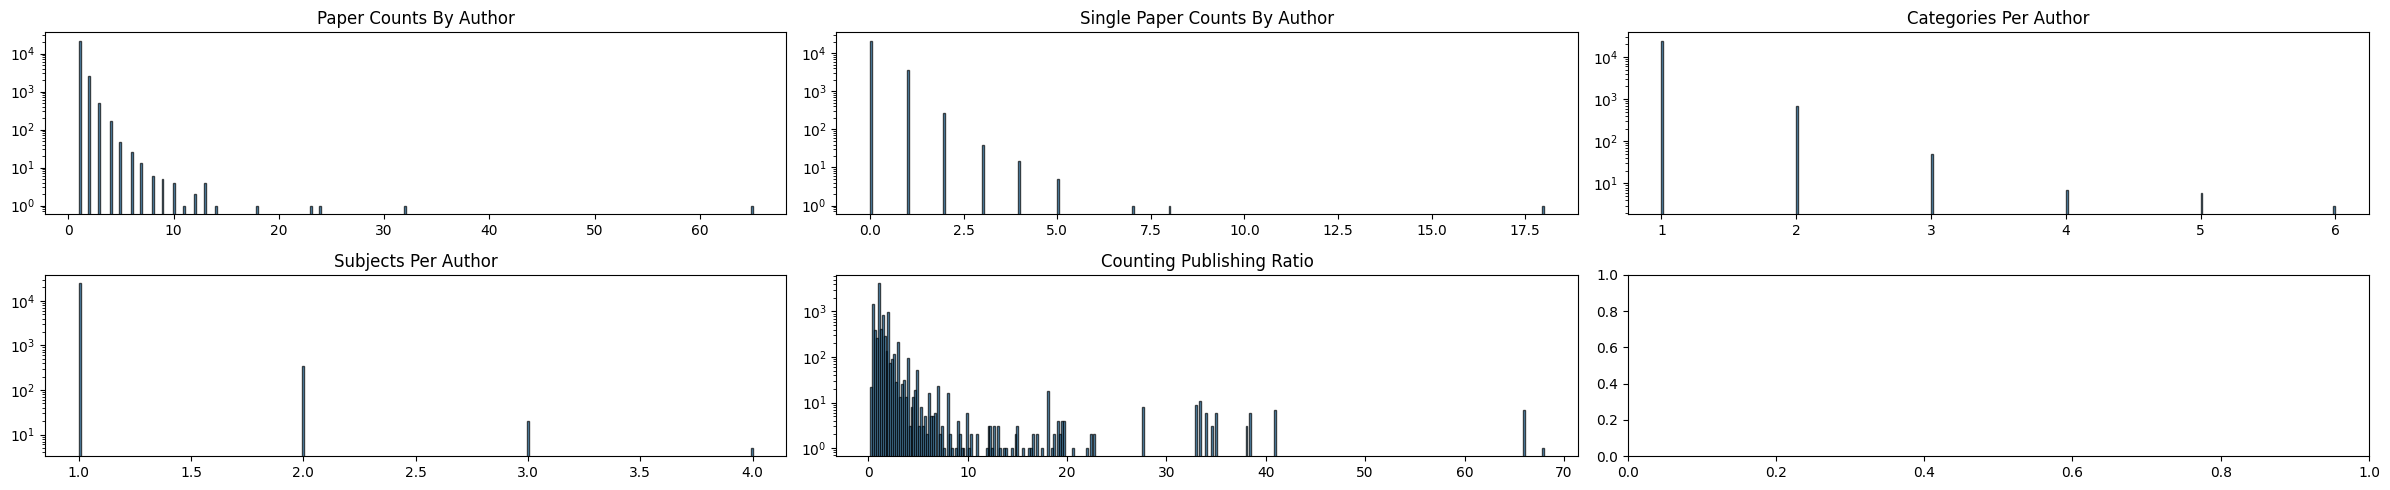

In [16]:
"""
A Generic Function To Plot The Distribution Of A Specified Column
"""
def plot_distribution(ax, data, title):
    ax.hist(data, bins=350, edgecolor="black", alpha=0.7)
    ax.set_yscale('log')
    ax.set_title(title)

fig, axes = plt.subplots(2, 3, figsize=(24, 5)) 

plot_distribution(axes[0,0], df_authors["papers"], "Paper Counts By Author")
plot_distribution(axes[0,1], df_authors["solo"], "Single Paper Counts By Author")
plot_distribution(axes[0,2], df_authors["mapped_category_count"], "Categories Per Author")
plot_distribution(axes[1,0], df_authors["subject_map_count"], "Subjects Per Author")
plot_distribution(axes[1,1], df_cleaned["total_papers"]/df_cleaned['contributors'], "Counting Publishing Ratio")
plt.tight_layout()
plt.show()

### NOTE: Alternative Embeddings

- Now we have the new dataframes, we can start with the alternative method, essentially all it is, is taking the embeddings we generated above for individual papers, using the embeddings of all papers an author has ever worked on to generate an "average" embedding of subject for each author, then redefining each paper using the embedding of each author who worked on it, 
- There are 3 methods below, each with unique weighting
- The first (paper_contribution_to_category) represents how each paper is weighted as part of its category definition, papers with higher importance are those with more contributors (more effort within the field) and those with higher publishing experience (total papers authors by them)

- The second (paper_contribution_to_author) represents how each paper is weighted as part of its definition for it author, papers with higher importance are those that happen later in career, papers with which this author led, and papers with fewer contributors. 

- The third (authors_contribution_to_paper) represents the weight to which each author contributes to each papers new embedding, authors with higher importance is the author who led the paper, individuals who published many papers, and inversely authors who wrote only one paper (as their embedding equals the initial embedding)


- Significance: The newly generated embedding, in addition to theoretical overlap takes into consideration real world coocurrance, and tendancy for practical overlap between categories, and range of papers within career

In [17]:
"""
Generates The Average Embeddings For A Category Using The Weighted Papers Within It
"""
def paper_contribution_to_category(group, chosen_embedding):
    return np.average(
        np.stack(group[chosen_embedding].values),
        axis = 0,
        weights = np.sqrt(group['contributors'].values) * #Use Contributor
                  np.sqrt(group['total_papers']/group['contributors']) #Higher Publishing experience
    )

"""
Generates The Average Author Embedding Using Weighted Papers They Contributed To
"""
def paper_contribution_to_author(group,chosen_embedding):
    
    duration = np.maximum(group['latest']-group['earliest'],1)
    point_within = group['year']-group['earliest']

    return np.average(
        np.stack(group[chosen_embedding].values),
        axis=0,
        weights=  np.log(point_within/duration + 2)*   #Use Point In Career
                   ( 1 + group['is_lead']*3 ) *   #Role In Paper
                  (np.power(1 / group['contributors'], 0.5))  # Inverse Contributors 
    )


"""
Generates The Average Paper Embedding Usings Weighted Authors That Contributed To It
"""
def authors_contribution_to_paper(group, chosen_embedding):
    return np.average(
        np.stack(group[chosen_embedding].values),
        axis=0,
        weights=  ( 1 + group['is_lead']*3 ) * #More If Author Leading It
                    np.sqrt(group['papers']) * #Move If Many Papers Made
                    (1 - 0.9 * (group['papers'] == 1)) #Less If This Is Only Paper Made By Author (Dilutes)
    )

### NOTE: Generating New Embeddings

- Can then apply these methods to generate alternative embeddings, allowing user to specify their desired base embedding to use (important if we are comparing methods)

In [18]:
""""
A Method That Generates An Alternative Embedding For A Paper, By Generating An Embedding For Each Author, Then Aggregating Each Papers Contributors Embeddings
"""
def generate_alternative_embeddings(chosen_embeddings, contributions):

    #Generate Author Embedding
    author_embeddings = (
        contributions
        .groupby('contributor')
        .apply(lambda group: paper_contribution_to_author(group,chosen_embeddings), include_groups=False)
        .reset_index(name = "author_" + chosen_embeddings)
    )

    #Merge To Join This Data
    contributions = contributions.merge(author_embeddings, on='contributor', how='left')

    #Generate New Paper Embedding
    alternative_embeddings = (
        contributions
        .groupby('id')
        .apply(lambda group: authors_contribution_to_paper(group, "author_" + chosen_embeddings), include_groups=False)
        .sort_index()
        .reset_index(name= "alternative_" + chosen_embeddings)
    )

    #Returning New Embedding
    return list(alternative_embeddings["alternative_" + chosen_embeddings])

### NOTE: Generating New Embeddings

- In addition to the 2 initial embeddings you had, added the joined version I added above

- ALTERNATIVE COMBOS CAN BE TRIED

In [19]:
df_cleaned['alternative_title_embeddings'] =    generate_alternative_embeddings( chosen_embeddings="title_embeddings",    contributions=df_contributions)
df_cleaned['alternative_abstract_embeddings'] = generate_alternative_embeddings(chosen_embeddings="abstract_embeddings", contributions=df_contributions)
df_cleaned['alternative_joined_embeddings'] = generate_alternative_embeddings(chosen_embeddings="joined_embeddings",    contributions=df_contributions)

### Cosine Similarity

This step calculates the cosine similarity between research papers based on their BERT-generated embeddings for titles and abstracts. Cosine similarity quantifies the degree of similarity between two vectors, making it a valuable metric for identifying papers with related content or topics.

The importance of this step is as follows:

- Identifying Similar Papers: Cosine similarity allows for the identification of research papers that are thematically or conceptually similar, based on the content of their titles and abstracts.
- Efficient Comparison: Cosine similarity offers a computationally efficient and effective method for comparing text data, facilitating quick similarity assessments.
- Application in Recommendation Systems: This metric is integral for developing recommendation models, as it helps suggest papers that share common themes or concepts, aiding in the discovery of relevant literature and minimizing redundancy in research.

In [20]:
# Calculate cosine similarity between all papers based on their title and abstract embeddings
title_sim_matrix = cosine_similarity(df_cleaned['title_embeddings'].tolist())
abstract_sim_matrix = cosine_similarity(df_cleaned['abstract_embeddings'].tolist())

### Category Similarity Comparison
This code computes and visualizes the similarity between research paper categories based on their title and abstract embeddings. The function CompareAll calculates the mean similarity between categories by comparing each paper in one category to its most similar papers in another category, using a precomputed similarity matrix.

The function iterates through all category pairs and finds the most similar articles across categories. It then computes an average similarity score for each category pair and stores the results in a difference matrix. The diagonal values, representing self-comparisons, are set to zero initially but later replaced with NaN for better visualization.

A heatmap is then generated to display these similarity differences, using a color gradient to indicate how closely related different research categories are. This visualization helps identify relationships between research areas, revealing clusters of related topics.

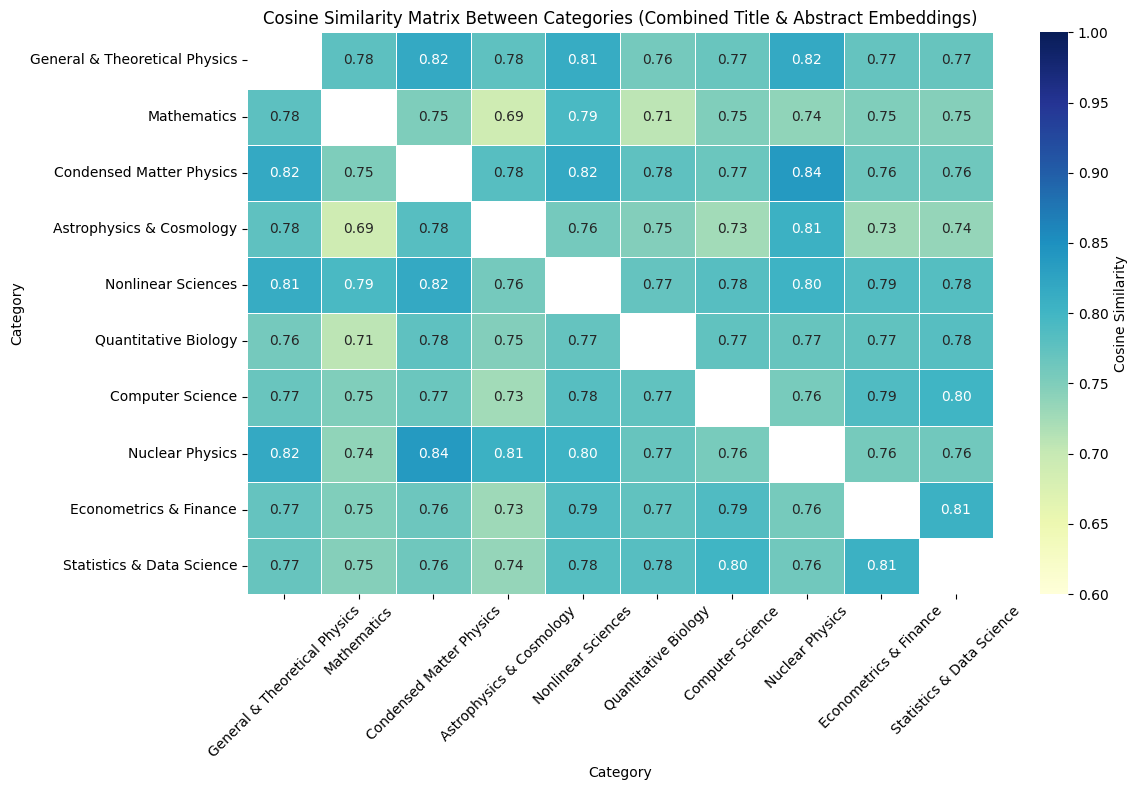

In [21]:

# Function to compute cosine similarity matrix between categories using combined embeddings
def compute_combined_category_similarity_matrix(title_column, abstract_column, df):

    # Combine title and abstract embeddings by averaging them
    combined_embeddings = np.array([0.5 * (title + abstract) for title, abstract in zip(df[title_column], df[abstract_column])])

    # Compute cosine similarity between all combined embeddings
    similarity_matrix = cosine_similarity(combined_embeddings)

    # Get the unique categories
    categories = df['subject_map'].unique()

    # Initialize a matrix to store average similarity scores between categories
    category_sim_matrix = np.zeros((len(categories), len(categories)))

    # Loop over all pairs of categories
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):

            # Get the indices for both categories
            indices1 = df[df['subject_map'] == cat1].index
            indices2 = df[df['subject_map'] == cat2].index

            # Get the cosine similarity between all pairs of documents in category cat1 and cat2
            similarity_values = similarity_matrix[np.ix_(indices1, indices2)]

            # Calculate the mean similarity for this category pair
            category_sim_matrix[i, j] = np.mean(similarity_values)

    # Convert the similarity matrix to a DataFrame with category labels
    category_sim_df = pd.DataFrame(category_sim_matrix, index=categories, columns=categories)

    return category_sim_df

# Compute the similarity matrix using combined title and abstract embeddings
category_similarity_df = compute_combined_category_similarity_matrix('title_embeddings', 'abstract_embeddings', df_cleaned)

# Set diagonal to NaN to avoid self-similarity being shown
np.fill_diagonal(category_similarity_df.values, np.nan)

# Plot the heatmap for the category similarity matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    category_similarity_df,
    cmap='YlGnBu',
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    vmin=0.6,  # Set the minimum value for color scale
    vmax=1,  # Set the maximum value for color scale
    cbar_kws={'label': 'Cosine Similarity'}
)

plt.title("Cosine Similarity Matrix Between Categories (Combined Title & Abstract Embeddings)")
plt.xlabel("Category")
plt.ylabel("Category")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

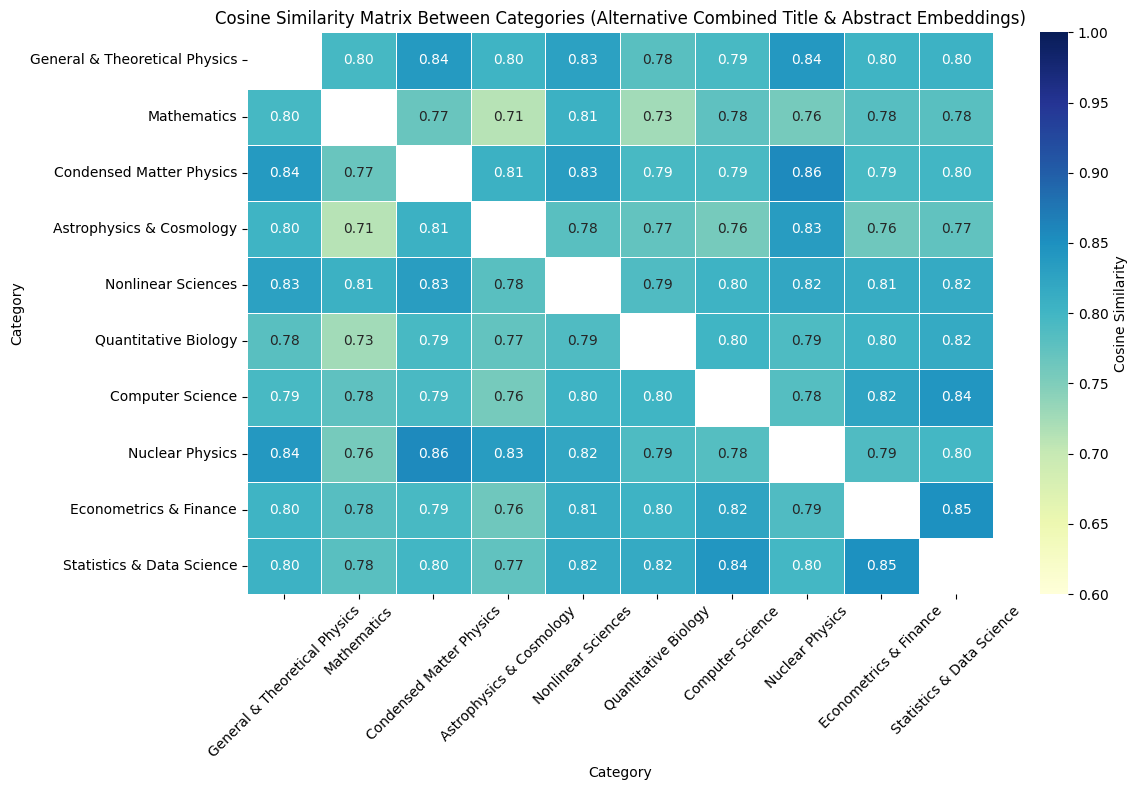

In [25]:
category_similarity_df = compute_combined_category_similarity_matrix('alternative_title_embeddings', 'alternative_abstract_embeddings', df_cleaned)

# Set diagonal to NaN to avoid self-similarity being shown
np.fill_diagonal(category_similarity_df.values, np.nan)

# Plot the heatmap for the category similarity matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    category_similarity_df,
    cmap='YlGnBu',
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    vmin=0.6,  # Set the minimum value for color scale
    vmax=1,  # Set the maximum value for color scale
    cbar_kws={'label': 'Cosine Similarity'}
)

plt.title("Cosine Similarity Matrix Between Categories (Alternative Combined Title & Abstract Embeddings)")
plt.xlabel("Category")
plt.ylabel("Category")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### NOTE: Category Similarity Comparison

- An Alternative Method That Allows Inputted Embeddings To Be used, with level of specificity (IE: subject_map vs categories)
- Method also makes use of above function to weigh each paper by above rules

In [ ]:
"""
Generates Group Based Embedding Average
"""
def aggregate_groups(df, embedding, categories):
    return (
        df
        .groupby(categories)
        .apply(lambda group: paper_contribution_to_category(group, embedding), include_groups=False)
        .reset_index(name='embeddings')
        .sort_values(by=categories)
    )


"""
Generates A Similarity Matrix
"""
def plot_similarity_matrix(ax, similarity, columns, title):
    visual = pd.DataFrame(similarity, index=columns, columns=columns)
    sns.heatmap(visual, ax=ax, annot=True)
    ax.set_title(title)

"""
Generates An (Optionally Normalized) Matrix To Display Differences In Similarity Between Categories Between Methods
"""
def comparing_embedding_similarity(df, embedding1, embedding2, categories, normalize=True):

    #Plotting Stuff
    fig, axes = plt.subplots(1,3, figsize=(30, 10))

    #Generating Grouped Embeddings
    grouped_embedding1 = aggregate_groups(df, embedding1, categories)
    grouped_embedding2 = aggregate_groups(df, embedding2, categories)

    cs1 = cosine_similarity(np.stack(grouped_embedding1['embeddings'].values))
    cs2 = cosine_similarity(np.stack(grouped_embedding2['embeddings'].values))

    #Groups
    columns =  grouped_embedding1[categories]

    plot_similarity_matrix(axes[0], cs1, columns, embedding1)
    plot_similarity_matrix(axes[1], cs2, columns, embedding2)


    #Difference In Similarity
    diff = cs1 - cs2

    #Optionally Normalize
    if normalize:
        diff = (diff - diff.mean()) / diff.std()

    plot_similarity_matrix(axes[2], diff, columns, "Normalized Difference")

    plt.plot()

### NOTE: Plotting Similarity Matrixs

- Comparing Methods (first sim, second sim, third normalized sim)

- ALTERNATIVE COMBOS CAN BE TRIED

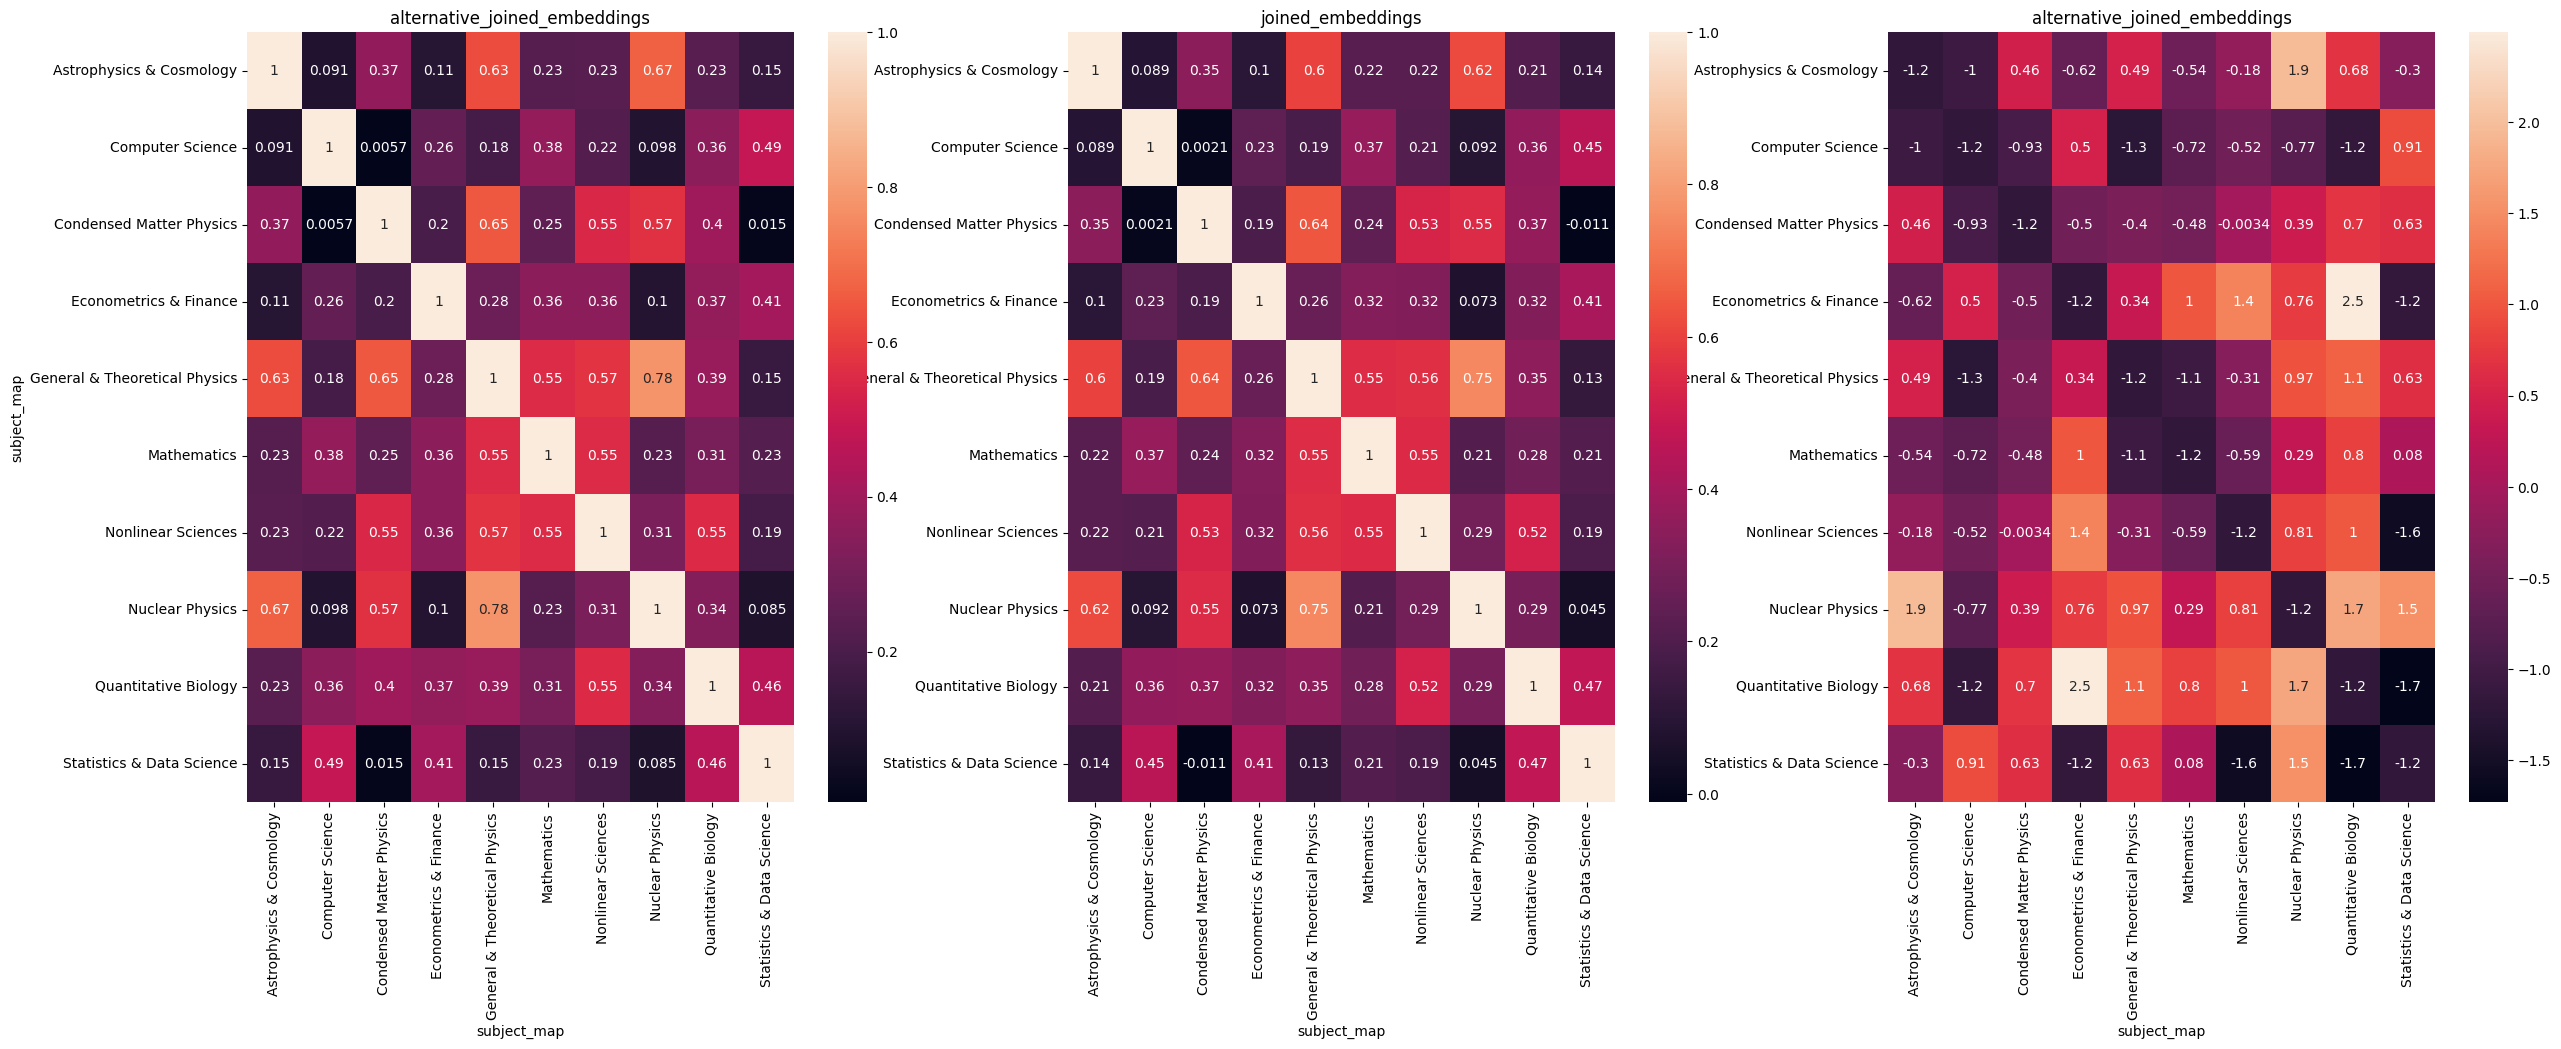

In [23]:
comparing_embedding_similarity(df_cleaned, 'alternative_joined_embeddings', "joined_embeddings", "subject_map")

### Paper Uniqueness Evaluation
This code computes and visualizes the uniqueness of research papers in different categories using similarity matrices based on their title and abstract embeddings. The function Uniqueness calculates how distinct a paper is by measuring its similarity to papers in different categories.

The function iterates through each paper and identifies the most similar papers from other categories. It then computes an average similarity score for these cross-category papers, which is used as a uniqueness score (higher similarity to other categories means lower uniqueness). These scores are stored in a new column, 'Uniquity', in df_cleaned.

The code then groups the uniqueness scores by subject and calculates the mean uniqueness score for each category. It generates bar charts to visualize the results, where lower scores indicate more unique subjects, and higher scores indicate greater overlap with other categories.

Importance:
- Assessing Paper Uniqueness: This metric provides insight into how distinct research papers are in terms of content, helping to identify which areas of research are more or less unique.
- Category Insights: The resulting visualizations show which research categories are more likely to overlap with others, which can guide further exploration of interdisciplinary research or highlight saturated topics.
- Enhanced Decision-Making: Understanding uniqueness can help researchers identify niches in the literature, potentially guiding future research into less-explored areas.

In [24]:
def Uniqueness(similarity_matrix):
    uniquity_scores = []  # Store uniqueness scores for each index

    for j in range(len(similarity_matrix)):  # Iterate over all indices
        mapped = df_cleaned.iloc[j]['subject_map']
        similar_indices = [i for i in similarity_matrix[j].argsort()[::-1][1:]if df_cleaned.iloc[i]['subject_map'] != mapped]
        sumb= 0
        for i in similar_indices:
            suma = similarity_matrix[j][i]
            sumb += suma
        lena = len(similar_indices)
        uniquity = sumb / lena  # Compute uniqueness score

        uniquity_scores.append(uniquity)  # Store score
    df_cleaned['Uniquity'] = uniquity_scores  # Assign all scores to dataframe column
    return uniquity_scores

Uniqueness(title_sim_matrix)

category_colors = {category: color for category, color in zip(categories, palette)}
subject_colors = {subject: color for subject, color in zip(subjects, palette)}


# Group by 'Subject' and calculate mean uniqueness
subject_uniquity = df_cleaned.groupby('subject_map')['Uniquity'].mean().sort_values()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=subject_uniquity.index, y=subject_uniquity.values, palette=subject_colors)
plt.xlabel('Average Uniquity Score (Lower is more Unique)')
plt.ylabel('Subject')
plt.title('Uniquity Score by Subject and Title')
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Show the plot
plt.show()

Uniqueness(abstract_sim_matrix)

# Group by 'Subject' and calculate mean uniqueness
subject_uniquity = df_cleaned.groupby('subject_map')['Uniquity'].mean().sort_values()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=subject_uniquity.index, y=subject_uniquity.values, palette=subject_colors)
plt.xlabel('Average Uniquity Score (Lower is more Unique)')
plt.ylabel('Subject')
plt.title('Uniquity Score by Subject and Abstract')
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Show the plot
plt.show()

KeyboardInterrupt: 

### PCA Visualization of Research Paper Distribution

This code computes and visualizes the distribution of research papers in a lower-dimensional space using Principal Component Analysis (PCA) on their title embeddings. The PCA transformation reduces the high-dimensional embeddings into two principal components, allowing for a 2D visualization of the paper embeddings.

The embeddings are first standardized using StandardScaler to ensure all features have a mean of 0 and a standard deviation of 1. PCA is then applied to project the data into a 2D space while preserving as much variance as possible.

The code generates two scatter plots to visualize the PCA-transformed embeddings. These visualizations help identify clusters, outliers, and relationships between research categories and subjects.

In [ ]:
# Perform PCA for dimensionality reduction (2D)
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(np.array(df_cleaned['title_embeddings'].tolist()))
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_embeddings)

# Map categories to colors
category_colors = {category: color for category, color in zip(categories, palette)}
subject_colors = {subject: color for subject, color in zip(subjects, palette)}

# Plot for mapped_categories
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=pca_result[:, 0],
    y=pca_result[:, 1],
    hue=df_cleaned['mapped_categories'],
    palette=category_colors,
    s=100,
    alpha=0.7
)
plt.title('PCA of Paper Embeddings Colored by Category')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Categories')
plt.show()

# Plot for subject_map
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=pca_result[:, 0],
    y=pca_result[:, 1],
    hue=df_cleaned['subject_map'],
    palette=subject_colors,
    s=100,
    alpha=0.7
)
plt.title('PCA of Paper Embeddings Colored by Subject')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Subjects')
plt.show()

### Cosine Similarity and Sankey Diagram Visualization

This code calculates the cosine similarity between the embeddings of research papers (based on their titles) and then generates a Sankey diagram to visualize the relationships between different research categories. By selecting a subset of categories from the subject_map column, it examines how papers within and across these categories compare in terms of content similarity.

A Sankey diagram is a flow diagram that visually represents the flow of quantities between different categories or groups. The width of the arrows (or "links") is proportional to the quantity being represented. In this case, the arrows indicate the degree of similarity between research categories, with thicker links showing stronger relationships.

Importance: 
- Understanding Relationships: It provides an intuitive way to understand the relationships between different research categories based on the content of the papers.
- Revealing Interdisciplinary Connections: By visualizing category similarities, researchers can identify overlapping areas between disciplines, guiding potential areas for interdisciplinary research.
- Efficient Exploration: The Sankey diagram offers a clear and compact way to explore complex similarity patterns.

In [ ]:
# Select a subset of 4 categories from the 'subject_map' column
desired_categories = df_cleaned['subject_map'].unique()[:4]

# Filter `df_cleaned` to include only papers with the categories in desired_categories
subset_df = df_cleaned[df_cleaned['subject_map'].isin(desired_categories)]

# Ensure that we have only the desired categories (excluding "Unknown Category")
subset_df = subset_df[subset_df['subject_map'] != 'Unknown Category']

# Check if the subset_df has enough data
print(f"Number of papers in subset_df: {len(subset_df)}")

# Compute similarity matrix for selected papers
paper_embeddings = np.stack(subset_df['title_embeddings'].values)
similarity_matrix = cosine_similarity(paper_embeddings)

print(f"Similarity matrix shape: {similarity_matrix.shape}")
print(f"Number of rows in subset_df: {len(subset_df)}")

# Compute category-to-category similarity (mean cosine similarity of papers)
category_pairs = defaultdict(float)
category_counts = defaultdict(int)

# Compute category similarity for pairs
for i, cat1 in enumerate(subset_df['subject_map']):
    for j, cat2 in enumerate(subset_df['subject_map']):
        if i < j:
            category_pairs[(cat1, cat2)] += similarity_matrix[i, j]
            category_counts[(cat1, cat2)] += 1

# Compute average similarities
category_avg_sim = {k: v / category_counts[k] for k, v in category_pairs.items()}

# Prepare data for Sankey diagram
source, target, value = [], [], []
for (cat1, cat2), sim in category_avg_sim.items():
    if sim > 0.3:
        source.append(cat1)
        target.append(cat2)
        value.append(sim)

# Create Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(source + target))  # Unique category names
    ),
    link=dict(
        source=[list(set(source + target)).index(s) for s in source],
        target=[list(set(source + target)).index(t) for t in target],
        value=value
    )
))

# Update layout for better spacing
fig.update_layout(
    title_text="Cross-Category Paper Similarity Sankey Diagram",
    font_size=10,
    height=800,
    width=1200
)

fig.show()

### Topic Modeling with LDA and Word Cloud Visualization

This code uses Latent Dirichlet Allocation (LDA) to perform topic modeling on the cleaned text data (title + abstract) of research papers. LDA is a statistical model that uncovers hidden topics within large collections of text. It works by analyzing the distribution of words across documents and grouping them into topics. The code generates a document-term matrix and applies LDA to identify the topics, displaying the top words for each topic. Word clouds are then created to visually represent the most frequent terms associated with each topic.

A word cloud is a visualization that shows words in varying sizes based on their frequency or significance in a given dataset. The most important or frequent words appear larger, making it easy to identify key themes or topics. In this case, the word clouds visually depict the key terms for each topic, helping to quickly capture the essence of each theme.

Importance:
*    Topic Discovery: LDA helps uncover the underlying themes or topics in large datasets, making it easier to understand the primary areas of focus in the research papers.

*    Text Summarization: The word clouds offer a concise and visual representation of the most important words within each topic, allowing for quick exploration and understanding of the dataset.

*    Improving Data Interpretation: Topic modeling aids in identifying common patterns or emerging trends in research, supporting better decision-making and guiding future research directions.


In [ ]:
# Apply CountVectorizer to the cleaned text data ('title' + 'abstract')
text_data = df_cleaned['title'] + " " + df_cleaned['abstract']

# Create a document-term matrix
vectorizer = CountVectorizer(stop_words='english')
dtm = vectorizer.fit_transform(text_data)

# Perform LDA (Latent Dirichlet Allocation)
num_topics = 5  # Set the number of topics
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(dtm)

# Display the top words for each topic
n_top_words = 5  # Number of top words to display for each topic
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic #{topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

# Word Cloud for Topics
def plot_word_cloud(topic_idx):
    plt.figure(figsize=(8, 6))
    wordcloud = WordCloud(
        background_color='white',
        width=800,
        height=400,
        max_words=100,
        colormap='viridis'
    ).generate_from_frequencies(dict(zip(feature_names, lda_model.components_[topic_idx])))
    plt.title(f"Topic {topic_idx + 1} Word Cloud")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Plot word clouds for the topics
for topic_idx in range(num_topics):
    plot_word_cloud(topic_idx)

# Assign dominant topic to each document
lda_topic_distribution = lda_model.transform(dtm)
df_cleaned['dominant_topic'] = lda_topic_distribution.argmax(axis=1)

# Use raw topic numbers (convert them to strings for plotting consistency)
df_cleaned['dominant_topic'] = df_cleaned['dominant_topic'].astype(str)

# Count occurrences of each topic per category
topic_category_counts = df_cleaned.groupby(['subject_map', 'dominant_topic']).size().reset_index(name='count')

# Create the grouped bar chart (Topic Distribution Across Research Categories)
fig = px.bar(
    topic_category_counts,
    x="subject_map",
    y="count",
    color="dominant_topic",
    barmode="group",
    title="LDA Topic Distribution Across Research Categories",
    labels={"count": "Number of Papers", "subject_map": "Research Categories", "dominant_topic": "Topic"},
    color_discrete_sequence=px.colors.qualitative.Set3
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()

# Assign dominant topic to each document using LDA topic distribution
lda_topic_distribution = lda_model.transform(dtm)
df_cleaned['dominant_topic'] = lda_topic_distribution.argmax(axis=1)
df_cleaned['dominant_topic'] = df_cleaned['dominant_topic']+1

# Convert dominant topics to string for consistent labeling
df_cleaned['dominant_topic'] = df_cleaned['dominant_topic'].astype(str) 

# Count occurrences of each topic within each research category
category_per_topic = df_cleaned.groupby(['dominant_topic', 'subject_map']).size().reset_index(name='count')

# Create a stacked bar chart (Dominant Categories in Each Topic)
fig2 = px.bar(
    category_per_topic,
    x="dominant_topic",
    y="count",
    color="subject_map",
    barmode="stack",
    title="Dominant Categories in Each Topic (LDA)",
    labels={"count": "Number of Papers", "dominant_topic": "Topic", "subject_map": "Research Categories"},
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig2.update_layout(xaxis_tickangle=-45)
fig2.show()

### Topic Modeling with NMF and Visualization

This code uses Non-Negative Matrix Factorization (NMF) to identify topics within research papers by analyzing the combined title and abstract embeddings. NMF is a dimensionality reduction technique that decomposes the input data into two non-negative matrices, revealing hidden structures. The embeddings of the papers are first normalized, and then NMF is applied to discover latent topics. The dominant topic for each paper is assigned based on the highest value in its topic distribution. Two visualizations are generated:

*   Topic Distribution Across Categories: A grouped bar chart showing how topics are distributed across different research categories.

*   Dominant Categories in Each Topic: A stacked bar chart displaying the number of papers from each category within each identified topic.

These visualizations help provide insights into how topics are represented in different categories and which categories dominate each topic.

Importance:
*   Topic Modeling: NMF allows for effective topic discovery by reducing the dimensionality of the embedding data, making it easier to group research papers based on their underlying topics.

*   Data Exploration: The visualizations help in understanding how topics are distributed across research categories and identifying which categories are dominant within each topic, offering insights into research trends.

*   Improved Decision-Making: By analyzing topic distributions, researchers can focus on emerging trends, refine categorization strategies, and guide future research directions.

In [ ]:
df_new = df_cleaned.copy()

# Combine Title and Abstract Embeddings
df_new['combined_embeddings'] = df_new.apply(lambda row: np.concatenate([row['title_embeddings'], row['abstract_embeddings']]), axis=1)

# Stack all embeddings to create a matrix of shape (num_documents, embedding_size)
embeddings_matrix = np.vstack(df_new['combined_embeddings'].values)

# Normalize the embeddings to make sure they are non-negative
scaler = MinMaxScaler()
embeddings_matrix_normalized = scaler.fit_transform(embeddings_matrix)

# Fit the NMF model on the normalized embeddings matrix
nmf_model = NMF(n_components=6, random_state=42)  # Change n_components as needed
nmf_model.fit(embeddings_matrix_normalized)

# Assign dominant topic to each paper
topic_distribution = nmf_model.transform(embeddings_matrix_normalized)
df_new['dominant_topic'] = topic_distribution.argmax(axis=1)

# Use raw topic numbers (no conversion to human-readable labels)
df_new['dominant_topic'] = df_new['dominant_topic'].astype(str)  # Convert to string for plotting

# Count occurrences of each topic per category
topic_category_counts = df_new.groupby(['subject_map', 'dominant_topic']).size().reset_index(name='count')

# Create the first grouped bar chart (Topic Distribution Across Research Categories)
fig1 = px.bar(
    topic_category_counts,
    x="subject_map",
    y="count",
    color="dominant_topic",
    barmode="group",
    title="Topic Distribution Across Research Categories (Raw Topics)",
    labels={"count": "Number of Papers", "subject_map": "Research Categories", "dominant_topic": "Topic"},
    color_discrete_sequence=px.colors.qualitative.Set3

)

fig1.update_layout(xaxis_tickangle=-45)
fig1.show()
category_per_topic = category_per_topic[category_per_topic['dominant_topic'] != '0']

# Create a second plot showing the dominant categories for each topic
category_per_topic = df_new.groupby(['dominant_topic', 'subject_map']).size().reset_index(name='count')

# Remove the first topic (smallest value)
min_topic = category_per_topic['dominant_topic'].astype(int).min()
category_per_topic = category_per_topic[category_per_topic['dominant_topic'] != str(min_topic)]

fig2 = px.bar(
    category_per_topic,
    x="dominant_topic",
    y="count",
    color="subject_map",
    barmode="stack",
    title="Dominant Categories in Each Topic",
    labels={"count": "Number of Papers", "dominant_topic": "Topic", "subject_map": "Research Categories"},
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig2.update_layout(xaxis_tickangle=-45)
fig2.show()

###  GUI for Article Recommendations
This code implements a simple graphical user interface (GUI) using the Tkinter library to allow users to find articles similar to a given article based on their title. The main function get_recommendations retrieves the top N articles similar to the user-provided article ID, and get_recommendationsOF fetches similar articles from different categories. The interface includes an input field for entering the article ID, a search button, and displays the title and category of the input article along with the top N recommendations.

When the user enters a valid article ID, the recommendations are displayed in two sections: one showing similar articles and the other displaying articles from different categories. The application provides an intuitive and visually appealing way to explore research papers and their relationships based on content similarity and category.

**Note: This GUI is designed to be run on a local desktop environment, such as through an IDE like Visual Studio Code (VSCode) or directly on your computer. It is not suitable to run in a cloud-based environment like Google Colab, as Colab does not support interactive desktop applications like Tkinter.**

In [ ]:
import tkinter as tk
from tkinter import *
from tkinter.ttk import *

def get_recommendations(index, top_n=5, similarity_matrix=title_sim_matrix):

    similar_indices = similarity_matrix[index].argsort()[::-1][1:top_n + 1]

    recommendations = []

    for idx in similar_indices:

        recommendations.append({
            'paper_title': df_cleaned.iloc[idx]['title'],
            'similarity_score': similarity_matrix[index][idx]
        })

    return recommendations

def get_recommendationsOF(index, top_n=5, similarity_matrix=title_sim_matrix):

    mapped = df_cleaned.iloc[index]['subject_map']

    similar_indices = [i for i in similarity_matrix[index].argsort()[::-1][1:]if df_cleaned.iloc[i]['subject_map'] != mapped][:top_n]

    recommendations = []

    for idx in similar_indices:

        recommendations.append({
            'paper_title': df_cleaned.iloc[idx]['title'],
            'similarity_score': similarity_matrix[index][idx],
            'mapped_categories1': df_cleaned.iloc[idx]['mapped_categories']
        })

    return recommendations, mapped

# Function to handle button click
def on_button_click():

    user_input = entry.get().strip()

    if not user_input:

        result_label.config(text="Please enter a valid article ID.", fg="red")
        return

    try:

        intValue = int(user_input)  # Ensure input is a number
        recommendations = get_recommendations(intValue, top_n=5, similarity_matrix=title_sim_matrix)
        recommendationsOF, mapped = get_recommendationsOF(intValue, top_n=5, similarity_matrix=title_sim_matrix)

        # Formatting recommendations
        result_text = "\n".join(
            f"⭐ Recommendation {i + 1}: {rec['paper_title']} (Similarity: {rec['similarity_score']:.3f})"
            for i, rec in enumerate(recommendations)
        )

        result_label.config(text=result_text, fg="black")

        result_text2 = "\n".join(
            f"🔹 Recommendation {i + 1}: {rec['paper_title']} (Similarity: {rec['similarity_score']:.3f}) (Category: {rec['mapped_categories1']})"
            for i, rec in enumerate(recommendationsOF)
        )

        result_label2.config(text=result_text2, fg="black")

        # Update labels
        label.config(text=f"📖 Title of Article: {df_cleaned.iloc[intValue]['title']}")
        cat.config(text=f"📂 Category: {mapped}")

    except (ValueError, IndexError):

        result_label.config(text="Invalid article ID.", fg="red")

# Create main window
root = tk.Tk()
root.title("📚 Similar Article Finder")
root.geometry("1200x500")
root.configure(bg="#F4F4F4")  # Light gray background

# Styling
HEADER_FONT = ("Segoe UI Bold", 14)
LABEL_FONT = ("Segoe UI", 11)
RESULT_FONT = ("Segoe UI", 10)

# Title Label
title_label = tk.Label(root, text="🔍 Find Similar Articles", font=HEADER_FONT, bg="#F4F4F4", fg="#2C3E50")
title_label.pack(pady=10)

# Input Section
input_frame = tk.Frame(root, bg="#F4F4F4")
input_frame.pack(pady=5)

label = tk.Label(input_frame, text="Enter an Article ID:", font=LABEL_FONT, bg="#F4F4F4")
label.grid(row=0, column=0, padx=5)

entry = tk.Entry(input_frame, font=("Arial", 12), width=10)
entry.grid(row=0, column=1, padx=5)

button = tk.Button(input_frame, text="Search", command=on_button_click, font=LABEL_FONT, bg="#3498DB", fg="white", padx=10)
button.grid(row=0, column=2, padx=5)

cat = tk.Label(root, text="", font=LABEL_FONT, bg="#F4F4F4", fg="#2C3E50")
cat.pack(pady=5)

# Similar Articles Section
frame1 = tk.Frame(root, bg="white", bd=2, relief="groove", padx=10, pady=5)
frame1.pack(fill="both", padx=20, pady=10)

title1 = tk.Label(frame1, text="📌 Similar Articles", font=HEADER_FONT, fg="#27AE60", bg="white")
title1.pack(anchor="w")

result_label = tk.Label(frame1, text="", font=RESULT_FONT, bg="white", justify="left", anchor="w")
result_label.pack(pady=5, anchor="w")

# Other Category Articles Section
frame2 = tk.Frame(root, bg="white", bd=2, relief="groove", padx=10, pady=5)
frame2.pack(fill="both", padx=20, pady=10)

title2 = tk.Label(frame2, text="📎 Articles from Other Categories", font=HEADER_FONT, fg="#E67E22", bg="white")
title2.pack(anchor="w")

result_label2 = tk.Label(frame2, text="", font=RESULT_FONT, bg="white", justify="left", anchor="w")
result_label2.pack(pady=5, anchor="w")

# Run the application
root.mainloop()